In [1]:
import numpy as np
import cupy as cp
from scipy.special import zeta, factorial
import scipy.integrate as integrate
from scipy.stats import norm
B_1 = -zeta(0.5)/np.sqrt(2 * np.pi)

def simMeanMaxGBM(drift, sigma, T, N, m):
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    max_bm = cp.max(paths, axis=1)
    return cp.mean(cp.exp(max_bm)), cp.exp(max_bm)

def exactMeanMaxGBM(r_, sigma, T):
    return (1 + sigma**2 / (2*r_)) * np.exp(r_*T) * norm.cdf((r_ + 0.5 * sigma**2)*T/(sigma * T**0.5)) + \
        norm.cdf(- (r_ - 0.5 * sigma**2) * T / (sigma*T**0.5)) * (1 - sigma**2 / (2 * r_))

# Here we will numerically integrate my own idea, with the correction added later

def toIntegrate(x, r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    def pdf(x):
        sqrtSigmaT = sigma * T**0.5
        return 1/sqrtSigmaT * norm.pdf((x - drift*T)/sqrtSigmaT) - 2 * drift / sigma**2 * np.exp(2 * drift*x / sigma**2) * norm.cdf((-x - drift * T)/sqrtSigmaT) +\
            np.exp(2 * drift * x / sigma**2) * norm.pdf((-x - drift * T)/sqrtSigmaT)/sqrtSigmaT
    def otherPdf(x):
        return 2 / (sigma * np.sqrt(2 * np.pi * T)) * np.exp(-1/(2 * sigma**2 * T) * (x-drift*T)**2) -\
            2 * drift/ sigma**2 * np.exp(2 * drift * x/ sigma**2)*norm.cdf((-x-drift*T)/(sigma * T**0.5))
    return x * pdf(np.log(x) + B_1 * sigma * np.sqrt(T/m) - np.log(S_0)) / x

def simProbMax0(r_, sigma, T, N, m):
    drift = r_ - 1/2 * sigma**2
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    res = cp.any(paths > 0, axis=1)
    return (cp.sum(~res) / N).get()

#Solution of the probability using the theory of Johans paper thm 2.1 (not rewritten) redone later
def exactProbMax0InfTime(r_, sigma, T, m):
    import numpy as np
    drift = r_ - 1/2 * sigma**2
    if drift >= 0:
        raise Exception("drift is larger or equal to 0, not allowed")
    B = - (drift / sigma) * np.sqrt(T/m) # this is beta
    r_values = np.arange(0, 150)
    zeta_vals = zeta(0.5 - r_values)
    summation = np.sum(zeta_vals/(factorial(r_values)*(2*r_values+1))* (-1)**r_values * (B**2 /2)**r_values)
    return np.exp(B / np.sqrt(2 * np.pi) * summation) * np.sqrt(2) * B

def own_first_order_approx_MC(S_0, r_, sigma, T, N, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * simProbMax0(r_, sigma, T, N, m)) - S_0

def own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * exactProbMax0InfTime(r_, sigma, T, m)) - S_0

def exact_price_cont_time(S_0, r_, sigma, T): # Checked with broadie paper
    return np.exp(-r_*T) * exactMeanMaxGBM(r_, sigma, T) * S_0 - S_0

# print(exact_price_cont_time(100, 0.1, 0.3, 0.5)) # sanity check with Broadie

def broadie_first_order_approx(S_0, r_, sigma, T, m): # checked with broadie
    v = exact_price_cont_time(S_0, r_, sigma, T)
    return (v + S_0) * np.exp(-B_1 * sigma * (T/m)**0.5) - S_0

# print(broadie_first_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie

def g(t, mu, T, sigma):
    return mu * T**0.5 / sigma * norm.cdf(mu * (T*t)**0.5/sigma) + \
           1 / np.sqrt(2 * np.pi * t) * np.exp(- mu**2 * T * t/(2 * sigma**2))


# todo add that we can add multiple extra terms for diff in mean M and M_tilde
def broadie_second_order_approx(S_0, r_, sigma, T, m):
    v = exact_price_cont_time(S_0, r_, sigma, T)
    mu = r_ - 0.5 * sigma**2
    B_2 = 0.425
    term = 1 - B_1 * sigma * T**0.5/m**0.5 + (2*g(1, mu, T, sigma) * sigma * T**0.5 - mu * T + 2 * B_2 * sigma**2 * T)/ (4*m)
    return (v + S_0) * term - S_0

# print(broadie_second_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie, note I use the representation of my paper but answers are equivalent

def sim_price_lookback_put(S_0, r_, sigma, T, N, m):
    drift = r_ - 0.5 * sigma ** 2
    sims_done = 0
    max_gbws = cp.array([], dtype="float32")
    while sims_done < N:
        N_step = cp.min(np.array([100000000//m, N - sims_done])).item()
        mean_GBM, max_gbw = simMeanMaxGBM(drift, sigma, T, N_step, m)
        max_gbws = cp.concatenate((max_gbws, max_gbw))
        sims_done += N_step
    return cp.exp(-r_ * T) * cp.mean(max_gbws) * S_0 - S_0, max_gbws

C:\Users\Wouter\anaconda3\envs\simulations\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [ ]:
mean, max_gbw = sim_price_lookback_put(100, 0.1, 0.3, 0.5, 10000000, 7)
print(mean, np.mean(max_gbw), np.exp(-0.1*0.5) * 100 * np.std(max_gbw) / np.sqrt(10000000))

x_points = np.arange(1, 101)
sims = np.zeros((x_points.size, 4))
r_ = 0.1
sigma = 0.3
T = 0.5
# from timeit import default_timer as timer # Time simulations
# start = timer()
# sim_price_lookback_put(100, r_, sigma, T, 100000000, 100)
# end = timer()
# print("Time", end - start) # Time in seconds, e.g. 5.38091952400282
# for i in range(0, x_points.size):
#     m = i+1
#     sims[i,:] = np.array([exact_price_cont_time(100, r_, sigma, T), broadie_first_order_approx(100, r_, sigma, T, m)
#         , broadie_second_order_approx(100, r_, sigma, T, m), sim_price_lookback_put(100, r_, sigma, T, 10000000, m)[0]])

In [144]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
plt.plot(x_points, sims[:, 0], label="Continuous time")
plt.plot(x_points, sims[:, 1], label="First order approximation")
plt.plot(x_points, sims[:, 2], label="Second order approximation")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different approximations")
plt.legend()
plt.grid()
plt.show()
plt.savefig('histogram.pgf')

print(sims[79])

<ipython-input-144-d465f421f736>:22: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


ValueError: Error processing '\(\displaystyle {−20}\)'
LaTeX Output:

! Package inputenc Error: Unicode character − (U+2212)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
<*> ...0000}\selectfont \(\displaystyle {−20}\)}
                                                  
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on texput.log.


In [41]:
import pandas as pd
# Table of every 20 points, note first point is m = 1
print(sims[39])
m_points = cp.array(range(19,100,20))
m_points = cp.asnumpy(m_points)
print(sims[m_points, 1:])
df = pd.DataFrame(np.round(sims[m_points, 1:], 5), index=m_points+1, columns=["First order", "Second order"
                                                                ,"Monte-carlo"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
print(df)

df.to_latex('differentPricesTable.tex')

[15.35255547 13.12034315 13.24908913 13.23602936]
[[12.20843054 12.46603994 12.44172872]
 [13.12034315 13.24908913 13.23602936]
 [13.52670075 13.61251401 13.60421283]
 [13.76963219 13.83398434 13.83513119]
 [13.93571506 13.98719253 13.98795415]]
m   First order Second order Monte-carlo
20     12.20843     12.46604    12.44173
40     13.12034     13.24909    13.23603
60      13.5267     13.61251    13.60421
80     13.76963     13.83398    13.83513
100    13.93572     13.98719    13.98795


In [18]:
r_ = -0.005
sigma = 0.3
T = 0.5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 1000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximations", sims)
np.save("x_pointsfirstOrderApproximations", x_points)

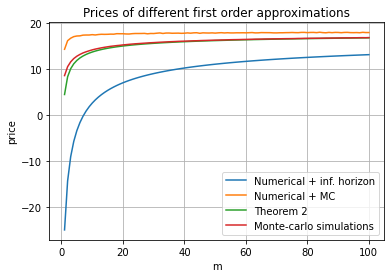

In [19]:
sims = np.load("firstOrderApproximations.npy")
x_points = np.load("x_pointsfirstOrderApproximations.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# plt.savefig('firstOrderApproximations.pgf')

In [13]:
# first order approximations with different parameters

r_ = -0.1
sigma = 0.5
T = 5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 1000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximationsPic2", sims)
np.save("x_pointsfirstOrderApproximationsPic2", x_points)

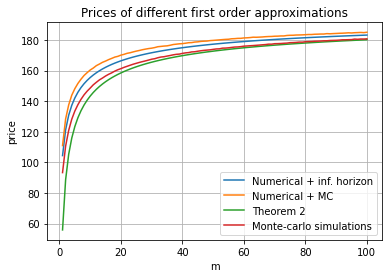

In [14]:
sims = np.load("firstOrderApproximationsPic2.npy")
x_points = np.load("x_pointsfirstOrderApproximationsPic2.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# plt.savefig('firstOrderApproximations.pgf')